<a href="https://colab.research.google.com/github/namjir/UGG-team3.github.io/blob/main/24510025_%EB%82%A8%EC%A7%80%EB%A5%B4_%EC%9A%94%EC%9D%B8%EB%B6%84%EC%84%9D%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 설치 (Colab 환경에서 factor_analyzer가 없는 경우 실행)
# 경고: pip는 시스템 경로에 설치되므로, Colab 런타임이 재시작되면 다시 설치해야 할 수 있습니다.
!pip install factor_analyzer # Colab에 이미 설치되어 있을 가능성 높음

# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from scipy import stats
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

print("라이브러리 로드 완료.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=4a288bbb6692b81900c66af1e39714776d0218355399f5c0c8c5f6213347de6c
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer
라이브러리 로드 완료.


In [ ]:
from google.colab import files
uploaded = files.upload()   # 파일 선택창이 뜸

Saving test_data.xlsx to test_data.xlsx


In [ ]:
# Load the data from the uploaded Excel file
df = pd.read_excel('test_data.xlsx')
# Display the first few rows to confirm it's loaded correctly
display(df.head())

,age,country,status,use,sat,image,recom
0,1,2,1,3,4,편리한 생활 파트너 (Амьдралд хэрэтэй тохиромжтой),4
1,1,2,1,3,4,특별한 이미지 없음(Тодорхой бодолгүй),4
2,1,2,1,3,3,편리한 생활 파트너 (Амьдралд хэрэтэй тохиромжтой),3
3,2,2,2,3,5,특별한 이미지 없음(Тодорхой бодолгүй),2
4,2,2,1,3,4,편리한 생활 파트너 (Амьдралд хэрэтэй тохиромжтой),4


In [ ]:
# 기초 통계량
print("\n📊 설문조사 데이터 기초 통계량")
print(df.describe())

# 각 항목별 빈도 분석
print("\n📌 항목별 빈도 분석")
for col in df.columns:
    print(f"\n[{col}]")
    print(df[col].value_counts().sort_index())

# 결측치 확인
print("\n❗ 결측치 현황")
print(df.isnull().sum())


📊 설문조사 데이터 기초 통계량
             age    country     status        use        sat      recom
count  32.000000  32.000000  32.000000  32.000000  32.000000  32.000000
mean    1.968750   1.468750   1.500000   2.156250   3.718750   3.093750
std     0.782237   0.507007   0.508001   0.677251   0.728869   0.777065
min     1.000000   1.000000   1.000000   1.000000   3.000000   1.000000
25%     1.000000   1.000000   1.000000   2.000000   3.000000   3.000000
50%     2.000000   1.000000   1.500000   2.000000   4.000000   3.000000
75%     3.000000   2.000000   2.000000   3.000000   4.000000   4.000000
max     3.000000   2.000000   2.000000   3.000000   5.000000   4.000000

📌 항목별 빈도 분석

[age]
age
1    10
2    13
3     9
Name: count, dtype: int64

[country]
country
1    17
2    15
Name: count, dtype: int64

[status]
status
1    16
2    16
Name: count, dtype: int64

[use]
use
1     5
2    17
3    10
Name: count, dtype: int64

[sat]
sat
3    14
4    13
5     5
Name: count, dtype: int64

[image]
image
기타

In [ ]:
# 신뢰도 분석 대상 문항
# 만약 더 많은 관련 문항이 있다면 해당 문항들을 포함
reliability_items = df[['use', 'sat', 'recom']]

# 크론바흐 알파 함수
def cronbach_alpha(df):
    k = df.shape[1]
    item_var = df.var(axis=0, ddof=1)
    total_var = df.sum(axis=1).var(ddof=1)
    return (k / (k-1)) * (1 - item_var.sum() / total_var) if k > 1 and total_var > 0 else np.nan

# 신뢰도 분석 결과
alpha = cronbach_alpha(reliability_items)
print(f"\n크론바흐 알파 (use, sat, recom): {alpha:.3f}")

# 해석 기준
print("신뢰도 해석: 0.7↑ 양호, 0.6~0.7 보통, 0.5~0.6 낮음, 0.5↓ 매우 낮음")


크론바흐 알파 (use, sat, recom): 0.046
신뢰도 해석: 0.7↑ 양호, 0.6~0.7 보통, 0.5~0.6 낮음, 0.5↓ 매우 낮음


In [ ]:
# 요인분석 대상 데이터 선택
# 'age', 'country', 'status'는 인구통계학적 변수이므로 일반적으로 요인 분석에서 제외
# 'use', 'sat', 'recom'이 요인 분석 대상이 될 수 있음
# ＇image＇는 텍스트이므로 제외
fa_data = df[['use', 'sat', 'recom']].copy()

# KMO와 Bartlett 검정
kmo_all, kmo_per_item = calculate_kmo(fa_data)
chi_square_value, p_value = calculate_bartlett_sphericity(fa_data)

# KMO 전체 측도 처리
if hasattr(kmo_all, "__iter__"):
    kmo_all_value = np.mean(kmo_all)
else:
    kmo_all_value = kmo_all

print(f"\nKMO 전체 측도: {kmo_all_value:.3f}")
if hasattr(kmo_per_item, "__iter__"):
    print("KMO 항목별 값:")
    for item, val in zip(fa_data.columns, kmo_per_item):
        print(f" - {item}: {val:.3f}")
else:
    print("KMO 항목별 값: 제공되지 않음")

print(f"\nBartlett 구형성 검정 카이제곱: {chi_square_value:.3f}, p-value: {p_value:.3f}")


KMO 전체 측도: 0.537
KMO 항목별 값: 제공되지 않음

Bartlett 구형성 검정 카이제곱: 3.203, p-value: 0.361


In [ ]:
# 자동 해석
if kmo_all_value < 0.6:
    print("⚠️ KMO 지수가 낮아 요인분석 적합하지 않을 수 있음")
if p_value >= 0.05:
    print("⚠️ Bartlett 검정 p-value가 0.05 이상 → 변수 간 상관이 충분하지 않음")

⚠️ KMO 지수가 낮아 요인분석 적합하지 않을 수 있음
⚠️ Bartlett 검정 p-value가 0.05 이상 → 변수 간 상관이 충분하지 않음


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

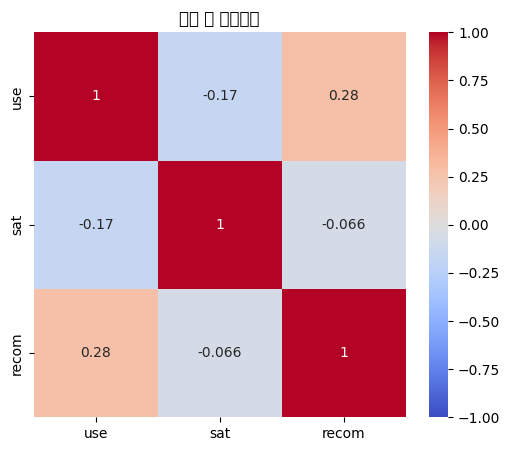

In [ ]:
# 변수 간 상관행렬 시각화
plt.figure(figsize=(6,5))
sns.heatmap(fa_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("변수 간 상관행렬")
plt.show()

In [ ]:
# 2️⃣ 한글 폰트 설정 (Colab)
!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
nanum_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(nanum_path)
plt.rc('font', family=fm.FontProperties(fname=nanum_path).get_name())
plt.rcParams['axes.unicode_minus'] = False

# 3️⃣ 요인분석 대상 데이터 선택
fa_data = df[['use', 'sat', 'recom']].copy()

# 4️⃣ KMO와 Bartlett 검정
kmo_all, kmo_per_item = calculate_kmo(fa_data)
chi_square_value, p_value = calculate_bartlett_sphericity(fa_data)

# KMO 처리
if hasattr(kmo_all, "__iter__"):
   kmo_all_value = np.mean(kmo_all)
else:
   kmo_all_value = kmo_all

print(f"\nKMO 전체 측도: {kmo_all_value:.3f}")
if hasattr(kmo_per_item, "__iter__"):
   print("KMO 항목별 값:")
   for item, val in zip(fa_data.columns, kmo_per_item):
       print(f" - {item}: {val:.3f}")
else:
   print("KMO 항목별 값: 제공되지 않음")


KMO 전체 측도: 0.537
KMO 항목별 값: 제공되지 않음


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


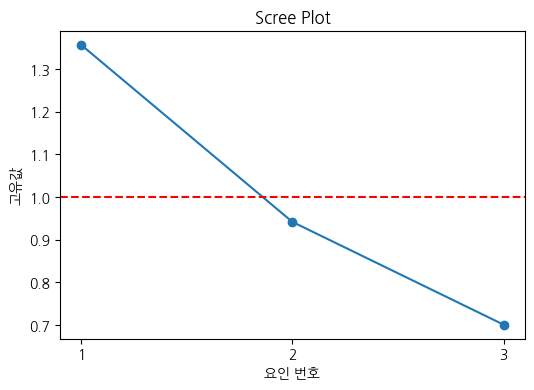

추천 요인 수 (고유값 > 1 기준): 1


In [ ]:
# 6️⃣ 요인 수 결정: 고유값 > 1 기준 + 스크리 플롯
fa = FactorAnalyzer(rotation=None)
fa.fit(fa_data)
ev, v = fa.get_eigenvalues()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.title("Scree Plot")
plt.xlabel("요인 번호")
plt.ylabel("고유값")
plt.xticks(range(1, len(ev)+1))
plt.axhline(y=1, color='r', linestyle='--')  # Kaiser 기준
plt.show()

# 고유값 > 1 기준 요인 수 추천
num_factors = sum(ev > 1)
print(f"추천 요인 수 (고유값 > 1 기준): {num_factors}")

In [ ]:
# 7️⃣ Varimax 회전 적용 EFA
fa_rotated = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa_rotated.fit(fa_data)

# 요인 적재량 출력
loadings = pd.DataFrame(fa_rotated.loadings_, index=fa_data.columns,
                       columns=[f'Factor{i+1}' for i in range(num_factors)])
print("\nVarimax 회전 후 요인 적재량 (Factor Loadings):")
print(loadings)

# 설명 분산
ev_rot, v_rot = fa_rotated.get_eigenvalues()
eigenvalues = pd.DataFrame({'Eigenvalue': ev_rot, 'Variance Explained': v_rot})


Varimax 회전 후 요인 적재량 (Factor Loadings):
        Factor1
use   -0.845506
sat    0.200471
recom -0.328496


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


In [ ]:
# 8️⃣ 요인점수 계산
factor_scores = fa_rotated.transform(fa_data)
factor_scores_df = pd.DataFrame(factor_scores,
                               columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# 9️⃣ 회귀분석 준비 (종속변수 'recom' 예시)
regression_data = pd.concat([df['recom'], factor_scores_df], axis=1)
X = regression_data.drop(columns='recom')
y = regression_data['recom']

# 상수항 추가
X = sm.add_constant(X)

# 회귀모형 적합
results = sm.OLS(y, X).fit()
print("\n회귀분석 결과 요약:")
print(results.summary())


회귀분석 결과 요약:
                            OLS Regression Results                            
Dep. Variable:                  recom   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.225
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0295
Time:                        11:51:20   Log-Likelihood:                -34.258
No. Observations:                  32   AIC:                             72.52
Df Residuals:                      30   BIC:                             75.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0938      0.129     24

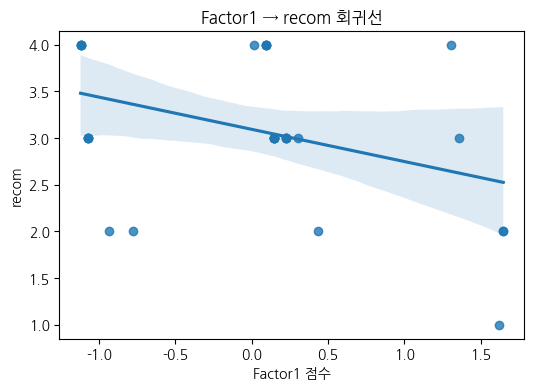

In [ ]:
# 10️⃣ 회귀선 시각화 (단일 요인일 때만)
if num_factors == 1:
   plt.figure(figsize=(6,4))
   sns.regplot(x='Factor1', y='recom', data=regression_data)
   plt.title("Factor1 → recom 회귀선")
   plt.xlabel("Factor1 점수")
   plt.ylabel("recom")
   plt.show()

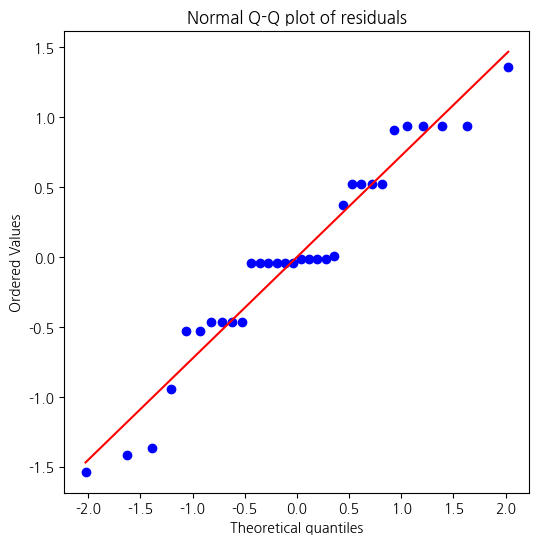

In [ ]:
# 11️⃣ 잔차 정규성 검정: Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(results.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q plot of residuals')
plt.show()